## Notes

Should I return the log of the scale as in julia

Should I include the confidence interval to the return levels

In [1]:
import os

os.add_dll_directory(
    "C:\\Users\\ospin\\miniconda3\\envs\\xhydro-dev\\julia_env\\pyjuliapkg\\install\\bin"
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Basic imports
try:
    from xhydro.extreme_value_analysis.parameterestimation import *

    has_julia = True
except ImportError:
    print(
        "This notebook requires the `julia` programming language and the `juliacall` Python package to be installed."
    )
    has_julia = False

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

# warnings.simplefilter("always", UserWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Données

In [2]:
GITHUB_URL = "https://github.com/hydrologie/xhydro-testdata"
BRANCH_OR_COMMIT_HASH = "main"

data = pooch.retrieve(
    url=f"{GITHUB_URL}/raw/{BRANCH_OR_COMMIT_HASH}/data/extreme_value_analysis/NOAA_GFDL_ESM4.zip",
    known_hash="md5:6c0f51c59add2f37b0e4af169b7eb7f6",
    processor=pooch.Unzip(),
)

df = pd.read_csv(data[0])
ds = df.to_xarray()
ds = ds.set_coords(["time", "station_num", "station_name"])
ds = ds.set_index(index=["station_num", "time"])
ds = ds.unstack("index")
ds

<xarray.Dataset> Size: 455kB
Dimensions:          (station_num: 97, time: 146)
Coordinates:
  * station_num      (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * time             (time) object 1kB '1955-01-01' ... '2100-01-01'
    station_name     (station_num, time) object 113kB 'Dozois' ... 'Romaine 4...
Data variables:
    qmax_yearly      (station_num, time) float64 113kB 424.0 805.1 ... 711.7
    total_precip     (station_num, time) float64 113kB 983.6 ... 1.065e+03
    max_temp_yearly  (station_num, time) float64 113kB 8.0 8.1 8.1 ... 4.4 4.6

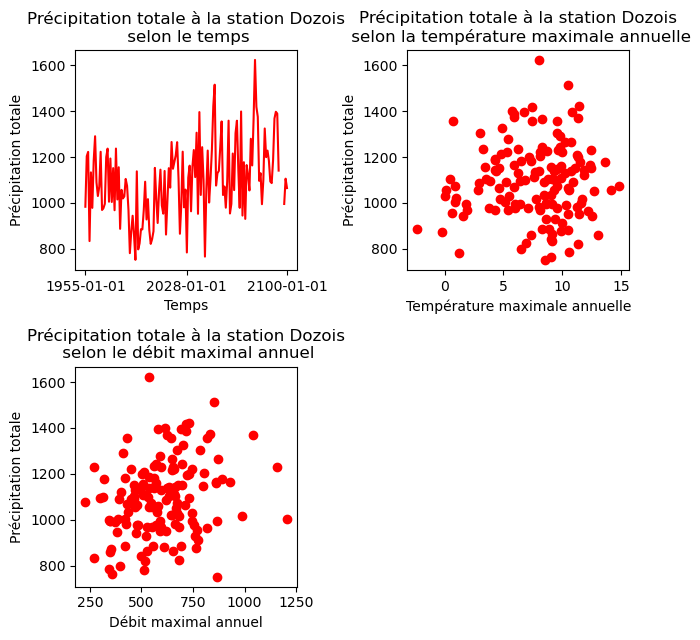

In [3]:
plt.rcParams["figure.figsize"] = [6.5, 6.5]  # Adjust the figure size
plt.rcParams["figure.autolayout"] = True

# First subplot
plt.subplot(2, 2, 1)  # 2x2 grid, first plot
y = ds.total_precip[0, :].values
x_1 = ds.time.values
plt.title("Précipitation totale à la station Dozois\n selon le temps")
plt.xlabel("Temps")
plt.ylabel("Précipitation totale")
plt.plot(x_1, y, color="red")

# Custom x-axis ticks
first_year = x_1[0]
last_year = x_1[-1]
middle_index = len(x_1) // 2
middle_year = x_1[middle_index]
plt.xticks([first_year, middle_year, last_year])

# Second subplot
plt.subplot(2, 2, 2)  # 2x2 grid, second plot
x_2 = ds.max_temp_yearly[0, :].values
plt.title(
    "Précipitation totale à la station Dozois\n selon la température maximale annuelle"
)
plt.xlabel("Température maximale annuelle")
plt.ylabel("Précipitation totale")
plt.scatter(x_2, y, color="red")

# Third subplot
plt.subplot(2, 2, 3)  # 2x2 grid, third plot
x_3 = ds.qmax_yearly[0, :].values
plt.title("Précipitation totale à la station Dozois\n selon le débit maximal annuel")
plt.xlabel("Débit maximal annuel")
plt.ylabel("Précipitation totale")
plt.scatter(x_3, y, color="red")

# Fourth subplot (empty)
plt.subplot(2, 2, 4)  # 2x2 grid, fourth plot (left empty)
plt.axis("off")  # Turn off the axis

plt.show()

## Estimation de paramètres - Stationnaire


In [4]:
params = fit(
    ds, dist="genextreme", method="ml", vars=["total_precip"], confidence_level=0.95
)
params

NameError: name 'param_cint' is not defined

## Estimation de paramètres - Non-Stationnaire

In [6]:
params = fit(
    ds,
    dist="genextreme",
    method="ml",
    vars=["total_precip"],
    locationcov=["max_temp_yearly"],
    distributed=True,
)
params

<xarray.Dataset> Size: 11kB
Dimensions:             (station_num: 97, dparams: 4)
Coordinates:
  * station_num         (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * dparams             (dparams) <U29 464B 'shape' 'loc' ... 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 3kB -0.1838 ... 148.3
    total_precip_lower  (station_num, dparams) float64 3kB -0.2783 ... 130.4
    total_precip_upper  (station_num, dparams) float64 3kB -0.08928 ... 168.6
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-10-23 17:07:44] fit: Estimate distribution parameters...

## Estimation de paramètres - Stationnaire: Attention au 0 dans l'intervalle!

In [21]:
params = fit(
    ds,
    dist="genextreme",
    method="ml",
    vars=["total_precip"],
    locationcov=["max_temp_yearly"],
    shapecov=["qmax_yearly"],
    distributed=True,
)
params

<xarray.Dataset> Size: 13kB
Dimensions:             (station_num: 97, dparams: 5)
Coordinates:
  * station_num         (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * dparams             (dparams) <U29 580B 'shape' ... 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 4kB -0.3134 ... 148.8
    total_precip_lower  (station_num, dparams) float64 4kB -0.7115 ... 130.7
    total_precip_upper  (station_num, dparams) float64 4kB 0.08478 ... 169.4
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 14:19:55] fit: Estimate distribution parameters...

## Niveau de retour - Stationnaire

In [12]:
ds

<xarray.Dataset> Size: 455kB
Dimensions:          (station_num: 97, time: 146)
Coordinates:
  * station_num      (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * time             (time) object 1kB '1955-01-01' ... '2100-01-01'
    station_name     (station_num, time) object 113kB 'Dozois' ... 'Romaine 4...
Data variables:
    qmax_yearly      (station_num, time) float64 113kB 424.0 805.1 ... 711.7
    total_precip     (station_num, time) float64 113kB 983.6 ... 1.065e+03
    max_temp_yearly  (station_num, time) float64 113kB 8.0 8.1 8.1 ... 4.4 4.6

In [13]:
params = fit(
    ds,
    dist="genpareto",
    method="bayes",
    vars=["total_precip"],
    locationcov=["max_temp_yearly"],
    shapecov=["qmax_yearly"],
    distributed=True,
)
params

ValueError: Pareto distribution has no location parameter and thus cannot have location covariates ['max_temp_yearly']

In [ ]:
dataset = xr.Dataset(
    {
        "var1": (["index"], var1),
        "var2": (["index"], var2),
        "var3": (["index"], var3),
    },
    coords={"index": range(len(var1))},  # Create an index coordinate
)

In [9]:
return_level_quantiles_stat = return_level(
    ds,
    dist="genpareto",
    method="bayes",
    vars=["total_precip"],
    return_period=2,
    threshold_pareto=1,
    nobs_pareto=146,
    nobsperblock_pareto=10,
)
return_level_quantiles_stat

┌ Warning: The maximum likelihood algorithm did not find a solution. Maybe try with different initial values or with another method. The returned values are the initial values.
└ @ Extremes C:\Users\ospin\.julia\packages\Extremes\4Tbee\src\parameterestimation\maximumlikelihood.jl:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: The maximum likelihood algorithm did not find a solution. Maybe try with different initial values or with another method. The returned values are the initial values.
└ @ Extremes C:\Users\ospin\.julia\packages\Extremes\4Tbee\src\parameterestimation\maximumlikelihood.jl:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
┌ Warning: The maximum likelihood algorithm did not find a solution. Maybe try with different initial values or with another method. The returned values are the initial values.
└ @ Extremes C:\Users\ospin\.julia\packages\Extremes\4Tbee\src\parameterestimation\maximumlikelihood.jl:20
C:\U

KeyError: 'return_level'

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [8]:
ds

<xarray.Dataset> Size: 455kB
Dimensions:          (station_num: 97, time: 146)
Coordinates:
  * station_num      (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * time             (time) object 1kB '1955-01-01' ... '2100-01-01'
    station_name     (station_num, time) object 113kB 'Dozois' ... 'Romaine 4...
Data variables:
    qmax_yearly      (station_num, time) float64 113kB 424.0 805.1 ... 711.7
    total_precip     (station_num, time) float64 113kB 983.6 ... 1.065e+03
    max_temp_yearly  (station_num, time) float64 113kB 8.0 8.1 8.1 ... 4.4 4.6

In [7]:
return_level_quantiles_stat = return_level(
    ds, dist="genextreme", method="ml", vars=["total_precip"], return_period=100
)
return_level_quantiles_stat

ValueError: conflicting sizes for dimension 'return_level': length 1 on 'return_level' and length 146 on {'station_num': 'station_num', 'return_level': 'total_precip'}

## Niveau de retour - Non-Stationnaire

In [10]:
return_level_quantiles_nstat = return_level(
    ds, dist="genextreme", method="pwm", vars=["total_precip"], return_period=100
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

ValueError: conflicting sizes for dimension 'return_level': length 1 on 'return_level' and length 146 on {'station_num': 'station_num', 'return_level': 'total_precip'}

In [ ]:
return_level_quantiles_nstat = return_level(
    ds,
    dist="genextreme",
    method="BAYES",
    vars=["total_precip"],
    return_period=100,
    locationcov=["max_temp_yearly"],
    distributed=True,
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


In [3]:
return_level_quantiles_nstat = return_level(
    ds.sel(station_num=[1001, 1004]),
    dist="genextreme",
    method="ml",
    vars=["total_precip"],
    return_period=100,
    locationcov=["max_temp_yearly"],
    distributed=True,
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

<xarray.Dataset> Size: 8kB
Dimensions:             (station_num: 2, return_level: 146)
Coordinates:
  * station_num         (station_num) int64 16B 1001 1004
  * return_level        (return_level) object 1kB '1955-01-01' ... '2100-01-01'
Data variables:
    total_precip        (station_num, return_level) float64 2kB 1.511e+03 ......
    total_precip_lower  (station_num, return_level) float64 2kB 1.434e+03 ......
    total_precip_upper  (station_num, return_level) float64 2kB 1.588e+03 ......
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-10-29 11:20:35] fit: Estimate distribution parameters...

In [15]:
return_level_quantiles_nstat = return_level(
    ds.sel(station_num=[1001, 1004]),
    dist="genextreme",
    method="ml",
    vars=["total_precip"],
    return_period=100,
    locationcov=["max_temp_yearly"],
    distributed=True,
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

<xarray.Dataset> Size: 8kB
Dimensions:             (station_num: 2, return_level: 146)
Coordinates:
  * station_num         (station_num) int64 16B 1001 1004
  * return_level        (return_level) object 1kB '1955-01-01' ... '2100-01-01'
Data variables:
    total_precip        (station_num, return_level) float64 2kB 1.511e+03 ......
    total_precip_lower  (station_num, return_level) float64 2kB 1.434e+03 ......
    total_precip_upper  (station_num, return_level) float64 2kB 1.588e+03 ......
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-10-29 11:55:09] fit: Estimate distribution parameters...

In [ ]:
return_level_quantiles_nstat = return_level(
    ds.sel(station_num=[1001, 1004]),
    dist="genextreme",
    method="ml",
    vars=["total_precip"],
    return_period=100,
    distributed=False,
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

In [5]:
return_level_quantiles_nstat = return_level(
    ds, dist="genpareto", method="ml", vars=["total_precip"], return_period=100
)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

ValueError: 'threshold_pareto', 'nobs_pareto', and 'nobsperblock_pareto' must be defined when using dist 'genpareto'.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert string dates to datetime objects
x = pd.to_datetime(ds.time.values)

plt.rcParams["figure.figsize"] = [12, 6.5]
plt.rcParams["figure.autolayout"] = True

y_1 = return_level_quantiles_nstat.total_precip[0, :].values
y_2 = [return_level_quantiles_stat.total_precip[0, :].values for _ in range(len(y_1))]

plt.title(
    "Précipitation totale de récurrence 1:1000 à Dozois - Stationnaire vs Non-Stationnaire"
)
plt.xlabel("Temps")
plt.ylabel("Niveau de retour")

# Custom x-axis ticks
first_year = x[0]
last_year = x[-1]
middle_year = x[len(x) // 2]
plt.xticks(
    [first_year, middle_year, last_year],
    labels=[first_year.year, middle_year.year, last_year.year],
)

# Plot both y_1 and y_2
plt.plot(x, y_1, color="red", label="Niveau de retour non stationnaire")
plt.plot(x, y_2, color="blue", label="Niveau de retour stationnaire")
plt.legend()
plt.show()

NameError: name 'return_level_quantiles_stat' is not defined

# Using dataset rain from Extremes.jl

In [1]:
import os

os.add_dll_directory(
    "C:\\Users\\ospin\\miniconda3\\envs\\xhydro-dev\\julia_env\\pyjuliapkg\\install\\bin"
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Basic imports
try:
    from xhydro.extreme_value_analysis.parameterestimation import *
    from xhydro.extreme_value_analysis.structures.util import *

    has_julia = True
except ImportError:
    print(
        "This notebook requires the `julia` programming language and the `juliacall` Python package to be installed."
    )
    has_julia = False

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import xarray as xr

# warnings.simplefilter("always«««", UserWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
df = pd.read_csv(
    "C:/Users/ospin/OneDrive/Documents/Wrapper/output_data_filter_exced.csv",
    index_col=0,
)

In [3]:
ds_rain = xr.Dataset.from_dataframe(df)
ds_rain

<xarray.Dataset> Size: 2kB
Dimensions:   (Date: 152)
Coordinates:
  * Date      (Date) object 1kB '1914-02-07' '1914-03-08' ... '1961-09-28'
Data variables:
    Rainfall  (Date) float64 1kB 1.8 2.5 1.8 14.5 0.5 ... 3.5 7.6 9.4 9.4 15.7

In [4]:
return_level(
    ds_rain,
    dist="genpareto",
    method="ML",
    vars=["Rainfall"],
    dim="Date",
    return_period=100,
    threshold_pareto=30.0,
    nobs_pareto=17531,
    nobsperblock_pareto=365,
)

AQUIIIIIIII
(array([106.32558691]), array([65.48163774]), array([147.16953608]))
(<xarray.DataArray 'Rainfall' (return_level: 1)> Size: 8B
array([106.32558691])
Dimensions without coordinates: return_level, <xarray.DataArray 'Rainfall' (return_level: 1)> Size: 8B
array([65.48163774])
Dimensions without coordinates: return_level, <xarray.DataArray 'Rainfall' (return_level: 1)> Size: 8B
array([147.16953608])
Dimensions without coordinates: return_level)


<xarray.Dataset> Size: 72B
Dimensions:         (return_level: 1)
Coordinates:
  * return_level    (return_level) <U12 48B 'return_level'
Data variables:
    Rainfall        (return_level) float64 8B 106.3
    Rainfall_lower  (return_level) float64 8B 65.48
    Rainfall_upper  (return_level) float64 8B 147.2
Attributes:
    long_name:    genpareto parameters
    description:  Parameters of the genpareto distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genpareto
    units:        
    history:      [2024-10-25 10:38:32] fit: Estimate distribution parameters...

## 1. genpareto

### 1.1 distribution

In [4]:
fit(
    ds_rain,
    dist="genpareto",
    method="ml",
    vars=["Rainfall"],
    dim="Date",
    confidence_level=0.95,
)

<xarray.Dataset> Size: 88B
Dimensions:         (dparams: 2)
Coordinates:
  * dparams         (dparams) <U5 40B 'scale' 'shape'
Data variables:
    Rainfall        (dparams) float64 16B 7.44 0.1845
    Rainfall_lower  (dparams) float64 16B 5.78 -0.01386
    Rainfall_upper  (dparams) float64 16B 9.577 0.3828
Attributes:
    long_name:    genpareto parameters
    description:  Parameters of the genpareto distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genpareto
    units:        
    history:      [2024-10-25 10:24:35] fit: Estimate distribution parameters...

### 1.2 return level

In [4]:
return_level(
    ds_rain,
    dist="genpareto",
    method="ML",
    vars=["Rainfall"],
    dim="Date",
    return_period=100,
    threshold_pareto=30.0,
    nobs_pareto=17531,
    nobsperblock_pareto=365,
)

AQUIIIIIIII


UnboundLocalError: cannot access local variable 'return_level' where it is not associated with a value

In [5]:
params = fit(
    ds_rain,
    dist="genpareto",
    method="pwm",
    vars=["Rainfall"],
    dim="Date",
    confidence_level=0.95,
)
params

<xarray.Dataset> Size: 88B
Dimensions:         (dparams: 2)
Coordinates:
  * dparams         (dparams) <U5 40B 'scale' 'shape'
Data variables:
    Rainfall        (dparams) float64 16B 7.299 0.1965
    Rainfall_lower  (dparams) float64 16B 5.792 0.01646
    Rainfall_upper  (dparams) float64 16B 9.453 0.3219
Attributes:
    long_name:    genpareto parameters
    description:  Parameters of the genpareto distribution
    method:       PWM
    estimator:    Probability weighted moments
    scipy_dist:   genpareto
    units:        
    history:      [2024-10-25 09:37:44] fit: Estimate distribution parameters...

In [7]:
f(3, 5)

(8, -2, 15)

In [6]:
import numpy as np
import xarray as xr

# Define the data for the DataArray
rainfall_data = np.array([2.0068965, 0.1844927])

# Create the DataArray with the specified dimension
rainfall = xr.DataArray(
    rainfall_data,
    dims="params",  # Dimension name
    name="Rainfall",  # Name of the DataArray
)

# Display the DataArray
print(rainfall)

<xarray.DataArray 'Rainfall' (params: 2)> Size: 16B
array([2.0068965, 0.1844927])
Dimensions without coordinates: params


In [10]:
rainfall2 = xr.DataArray(
    rainfall_data,
    dims="params3",  # Dimension name
    name="Rainfall2",  # Name of the DataArray
)

In [11]:
xr.merge(
    [
        rainfall.assign_coords(params=np.arange(2)),
        rainfall2.assign_coords(params3=np.arange(2)),
    ]
)

<xarray.Dataset> Size: 48B
Dimensions:    (params: 2, params3: 2)
Coordinates:
  * params     (params) int32 8B 0 1
  * params3    (params3) int32 8B 0 1
Data variables:
    Rainfall   (params) float64 16B 2.007 0.1845
    Rainfall2  (params3) float64 16B 2.007 0.1845

In [12]:
dataset = xr.Dataset({"Rainfall": rainfall, "Rainfallw": rainfall})

In [9]:
params = fit(
    ds_rain,
    dist="genpareto",
    method="ml",
    vars=["Rainfall"],
    dim="Date",
    confidence_level=0.95,
)
params

<xarray.Dataset> Size: 88B
Dimensions:         (dparams: 2)
Coordinates:
  * dparams         (dparams) <U5 40B 'scale' 'shape'
Data variables:
    Rainfall        (dparams) float64 16B 7.44 0.1845
    Rainfall_lower  (dparams) float64 16B 5.78 -0.01386
    Rainfall_upper  (dparams) float64 16B 9.577 0.3828
Attributes:
    long_name:    genpareto parameters
    description:  Parameters of the genpareto distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genpareto
    units:        
    history:      [2024-10-24 13:07:55] fit: Estimate distribution parameters...

In [16]:
d

<xarray.Dataset> Size: 56B
Dimensions:     (index: 2)
Coordinates:
  * index       (index) int32 8B 0 1
Data variables:
    params      (index) float64 16B 2.007 0.1845
    cint_lower  (index) float64 16B 1.754 -0.01386
    cint_upper  (index) float64 16B 2.259 0.3828

In [19]:
d[0]

KeyError: "No variable named 0. Variables on the dataset include ['params', 'cint_lower', 'cint_upper', 'index']"

In [18]:
exponentiate_logscale(d, [1], [2], pareto=True)

KeyError: "No variable named 0. Variables on the dataset include ['params', 'cint_lower', 'cint_upper', 'index']"

In [8]:
dataset = xr.Dataset(
    {
        key: (["index"], value)  # Assign data to the corresponding variables
        for key, value in params2.items()
    },
    coords={"index": np.arange(len(params2["params"]))},  # Create an index coordinate
)

In [10]:
dataset

<xarray.DataArray 'params' (index: 2)> Size: 16B
array([2.0068965, 0.1844927])
Coordinates:
  * index    (index) int32 8B 0 1

In [7]:
xr.DataArray(list(params2.values()), coords=[list(params2.keys())], dims=["keys"])

<xarray.DataArray (keys: 3)> Size: 12B
array([4, 5, 6])
Coordinates:
  * keys     (keys) <U10 120B 'params' 'cint_lower' 'cint_upper'

In [11]:
return_level(
    ds_rain,
    dist="genpareto",
    method="ML",
    vars=["Rainfall"],
    dim="Date",
    return_period=100,
    threshold_pareto=30.0,
    nobs_pareto=17531,
    nobsperblock_pareto=365,
)

<xarray.Dataset> Size: 56B
Dimensions:       (return_level: 1)
Coordinates:
  * return_level  (return_level) <U12 48B 'return_level'
Data variables:
    Rainfall      (return_level) float64 8B 106.3
Attributes:
    long_name:    genpareto parameters
    description:  Parameters of the genpareto distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genpareto
    units:        
    history:      [2024-10-23 17:59:02] fit: Estimate distribution parameters...

In [12]:
import numpy as np

In [13]:
np.log(7.44)

2.0068708488450007